In [1]:
# Accessing My Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Install the new version of opencv to use SIFT function
import cv2
!pip install opencv-contrib-python==4.4.0.44
print(cv2.__version__)

In [ ]:
# Check the python version
!python --version

Python 3.7.10


# Rectangular Panorama 


In [1]:
import numpy as np
import cv2
import math
import random
from google.colab.patches import cv2_imshow
from matplotlib import pyplot as mp

## load images and assign number to them in order
im1 = cv2.imread('/content/drive/MyDrive/mosaic-images/mosaico002.jpg')
im2 = cv2.imread('/content/drive/MyDrive/mosaic-images/mosaico003.jpg')
im3 = cv2.imread('/content/drive/MyDrive/mosaic-images/mosaico004.jpg')
im4 = cv2.imread('/content/drive/MyDrive/mosaic-images/mosaico005.jpg')
im5 = cv2.imread('/content/drive/MyDrive/mosaic-images/mosaico006.jpg')
im6 = cv2.imread('/content/drive/MyDrive/mosaic-images/mosaico007.jpg')
im7 = cv2.imread('/content/drive/MyDrive/mosaic-images/mosaico008.jpg')
im8 = cv2.imread('/content/drive/MyDrive/mosaic-images/mosaico009.jpg')
im9 = cv2.imread('/content/drive/MyDrive/mosaic-images/mosaico010.jpg')
im10 = cv2.imread('/content/drive/MyDrive/mosaic-images/mosaico011.jpg')



# Obtains n best matches between the two images by using BruteForce
def feature_matching_BFMatcher(img1, img2, n, drawing):
    # create the SIFT object:
    sift = cv2.xfeatures2d.SIFT_create()

    # obtain the keyPoints and descriptors of each image:
    kp_1, des_1 = sift.detectAndCompute(img1,None)
    kp_2, des_2 = sift.detectAndCompute(img2,None)

    # create the BFmatcher object: (BruteForce + CrossCheck)
    bf = cv2.BFMatcher(crossCheck=True)

    # extract the matches:
    matches = bf.match(des_1, des_2)

    # select good matches by adjusting the distance threshold, if want more matches included, increase the threshold 
    good_match = []
    for m in matches:
      if m.distance < 60: 
        good_match.append(m)
    good_match_arr = np.asarray(good_match)

    # sort best matches
    good_match = sorted(good_match_arr, key = lambda x:x.distance)

    # if we want to drawing our matched points by cv2.drawMatches later
    if drawing:
       return good_match[:n], kp_1, kp_2

    # adjust output matches format for later using in defined Image_Mosaic() function
    else:
        matches_BF = []
        for i in range(len(good_match)):
          A = [good_match[i]]
          matches_BF.append(A)

        return matches_BF[:n], kp_1, kp_2
     

# Obtains n best matches between the two images by using Lowe's criteria:
def feature_matching_KNN(img1, img2, n):
    # create the SIFT object:
    sift = cv2.xfeatures2d.SIFT_create()

    kp_1, des_1 = sift.detectAndCompute(img1,None)
    kp_2, des_2 = sift.detectAndCompute(img2,None)

    # use KNN to extract matches:
    bf = cv2.BFMatcher(crossCheck=False)
    matches = bf.knnMatch(des_1, des_2, k=2)
    
    # apply the Lowe's ratio:
    good_matches = []
    for m,z in matches:
      if m.distance < 0.7 * z.distance:
        good_matches.append([m])

    # sort best matches
    good_matches = sorted(good_matches, key = lambda x:x[0].distance)

    return good_matches[:n], kp_1, kp_2 
  


def show_detected_keypoints(img1, img2):
    # create the SIFT object:
    sift = cv2.xfeatures2d.SIFT_create()

    # obtain the keyPoints and descriptors of each image:
    kp_1, des_1 = sift.detectAndCompute(img1,None)
    kp_2, des_2 = sift.detectAndCompute(img2,None)

    # draw keypoints
    img1_kp = cv2.drawKeypoints(img1,kp_1, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    img2_kp = cv2.drawKeypoints(img2,kp_2, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

    # concatenate images 
    img_kp = np.concatenate((img1_kp, img2_kp ), axis=1)
    cv2_imshow(img_kp)
    
    # Saving the image
    filename = 'detected_kp.png'
    cv2.imwrite(filename, img_kp)
    return None


def show_feature_matching(img1, img2):
    # Comparison with 80 matched keypoints:
    matches_BF, kp1_bf, kp2_bf = feature_matching_BFMatcher(img1, img2, 80, True)
    matches_KNN, kp1_knn, kp2_knn = feature_matching_KNN(img1, img2, 80)
    matched_imgbf = cv2.drawMatches(img1, kp1_bf, img2, kp2_bf,  matches_BF, None, flags=2)
    matched_imgknn = cv2.drawMatchesKnn(img1, kp1_knn, img2, kp2_knn,  matches_KNN, None, flags=2)

    cv2_imshow(matched_imgbf)
    cv2_imshow( matched_imgknn)

    # Saving the image
    filename_1 = 'matched_imgbf.png'
    cv2.imwrite(filename_1, matched_imgbf)
    filename_2 = 'matched_imgknn.png'
    cv2.imwrite(filename_2, matched_imgknn)

    return None


# construct a mosaic
def Image_Mosaic(imgs):
    # Create the empty canvas for mosaic images
    canvas_x = imgs[0].shape[0] + 500 # define the row size of canvas
    summation = []
    for img in imgs:
      col = int(img.shape[1])
      summation.append(col)
    canvas_y = sum(summation) + 500 # define the col size of canvas, the col size increased when the number of mosaic inreased
    
    mosaic = np.zeros((canvas_x, canvas_y, 3), np.uint8) # create the image canvas

    # print(mosaic.shape) # check the image canvas size 

    # calculate the matches using KNN or BruteForce:
    matches = [tuple(feature_matching_BFMatcher(imgs[i], imgs[i+1], 110, False)) for i in range(len(imgs) - 1)]
    # matches = [tuple(feature_matching_KNN(imgs[i], imgs[i+1], 100)) for i in range(len(imgs) - 1)] # uncomment this line if want to use KNN matcher 
  
    # construct the matched points together
    points = []
    for match in matches:
        src = np.float32([match[1][m[0].queryIdx].pt for m in match[0]])
        dts = np.float32([match[2][m[0].trainIdx].pt for m in match[0]])
        points.append((src, dts))



    # compute the homographies:
    homographies = []
    for p in points:
      H = cv2.findHomography(p[0], p[1], cv2.RANSAC, 1.0)[0]
      homographies.append(H)



    # put the first image into the canvas
    M = np.array([[1,0,250], [0,1,250], [0,0,1]], np.float32) # M is 3×3 transformation matrix
    cv2.warpPerspective(src=imgs[0], dst=mosaic, M=M, dsize=(mosaic.shape[1], mosaic.shape[0]), flags = cv2.INTER_CUBIC, borderMode=cv2.BORDER_TRANSPARENT)
    del imgs[0]

    # inverse the matrix before doing perspective transformation since we need transform source images to our mosaic
    homographies_inv = []
    for h in homographies:
      h_inv = np.linalg.inv(h)
      homographies_inv.append(h_inv)

    
    # put other images into the canvas
    for img in imgs:
        # accumulate:
        M = M.dot(homographies_inv[0])
        # apply perspective transformation with cubic interpolation and using transparent border 
        cv2.warpPerspective(src=img, dst=mosaic, M=M, dsize=(mosaic.shape[1], mosaic.shape[0]), flags = cv2.INTER_CUBIC, borderMode=cv2.BORDER_TRANSPARENT)
        del homographies_inv[0]

    # remove zero in the mosaic:
    rows = []
    cols = []
    for i in range(mosaic.shape[0]):
      if np.all(mosaic[i] == 0): # check if all pixels in each row are zero
        rows.append(i)
    
    for j in range(mosaic.shape[1]):
      if np.all(mosaic[:j] == 0): # check if all pixels in each col are zero
        cols.append(j)
    mosaic = np.delete(mosaic, rows, 0) # remove zero rows
    mosaic = np.delete(mosaic, cols, 1) # remove zero cols
    
    return mosaic


# # show detected keypoints 
# show_detected_keypoints(im1, im2)

# # show feature matching 
# show_feature_matching(im1, im2)


# # show 2 images 
# imgs = [im1, im2]
# out_2 = Image_Mosaic(imgs)
# cv2_imshow(out_2)

# # show 3 images 
# imgs = [im1, im2, im3]
# out_3 = Image_Mosaic(imgs)
# cv2_imshow(out_3)

# ## show 10 images 
# imgs = [im1, im2, im3, im4, im5, im6, im7, im8, im9, im10]
# out_10 = Image_Mosaic(imgs)
# # print(out.shape)
# roi = out_10[58:300, 0:1021]
# cv2_imshow(roi)

# The output results 

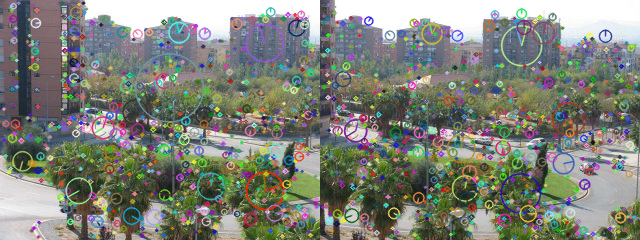

In [ ]:
# # show detected keypoints 
show_detected_keypoints(im1, im2)

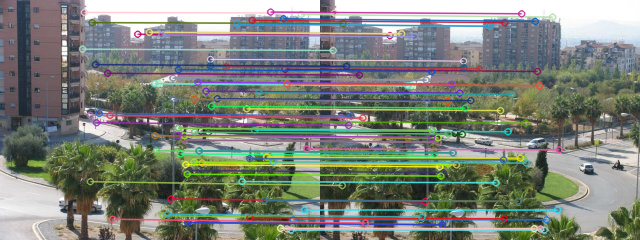

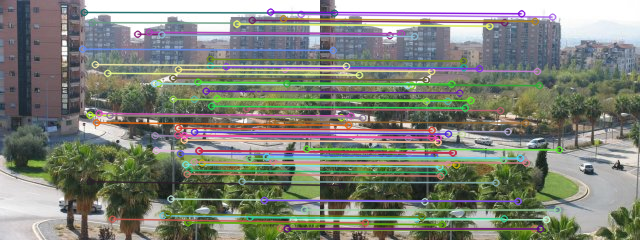

In [ ]:
# # show feature matching using BruteForce and KNN
show_feature_matching(im1, im2)

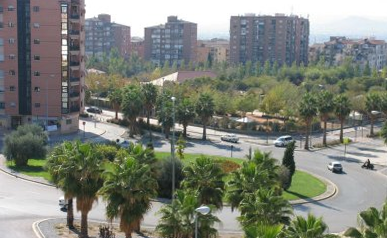

In [7]:
# show 2 images 
imgs = [im1, im2]
out_2 = Image_Mosaic(imgs)
# print(out_2.shape)
roi = out_2[5:243, 3:390] # crope image to exclude remined zero area
cv2_imshow(roi)

# Saving the image
# filename = 'panorama_2_img.png'
# cv2.imwrite(filename, roi)

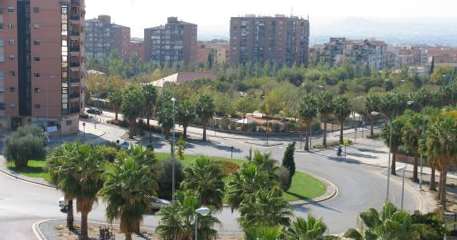

In [6]:
# show 3 images 
imgs = [im1, im2, im3]
out_3 = Image_Mosaic(imgs)
# print(out_3.shape)
roi = out_3[9:249, 8:465] # crope image to exclude remined zero area
cv2_imshow(roi)

# Saving the image
# filename = 'panorama_3_img.png'
# cv2.imwrite(filename, roi)

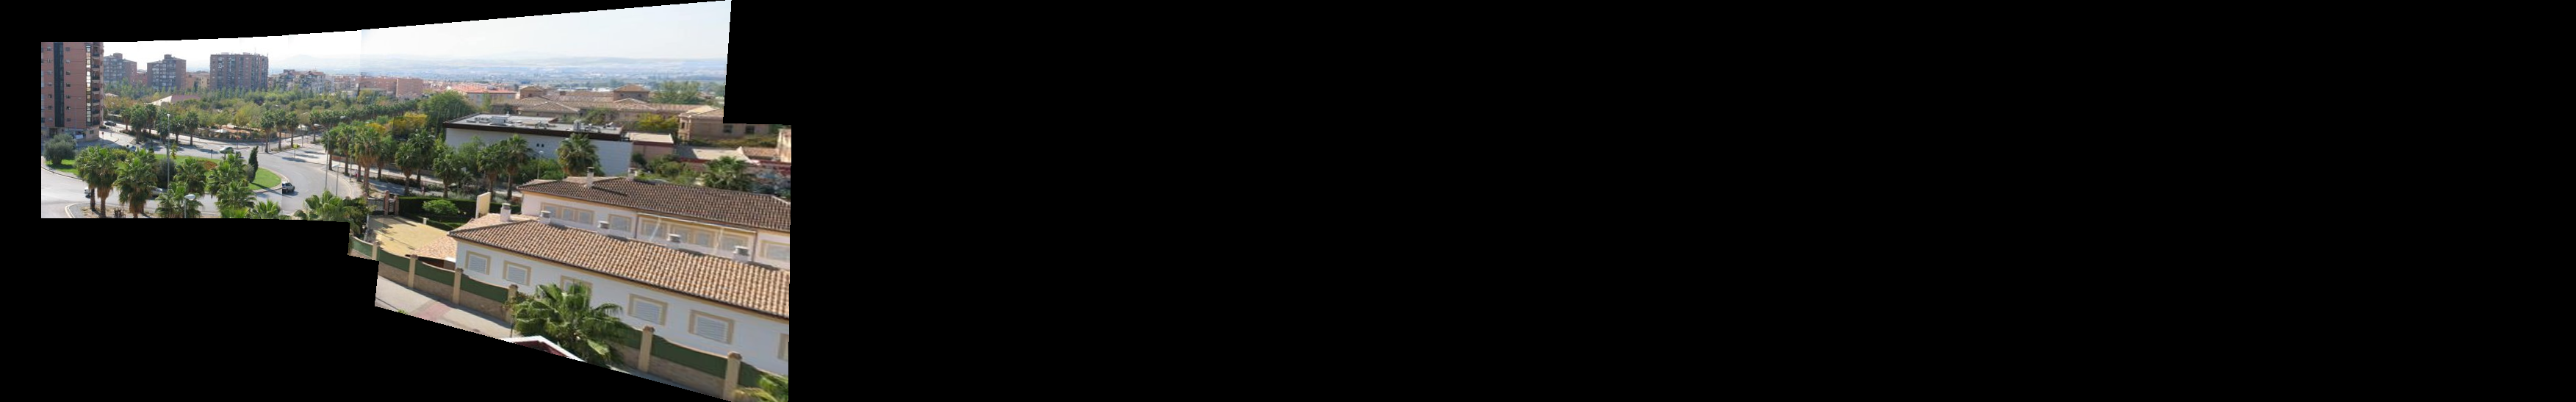

In [ ]:
## show 10 images without cropping 
imgs = [im1, im2, im3, im4, im5, im6, im7, im8, im9, im10]
out_10 = Image_Mosaic(imgs)
# print(out.shape)
cv2_imshow(out_10)

# Saving the image
# filename = 'panorama_10_img_full.png'
# cv2.imwrite(filename, out_10)

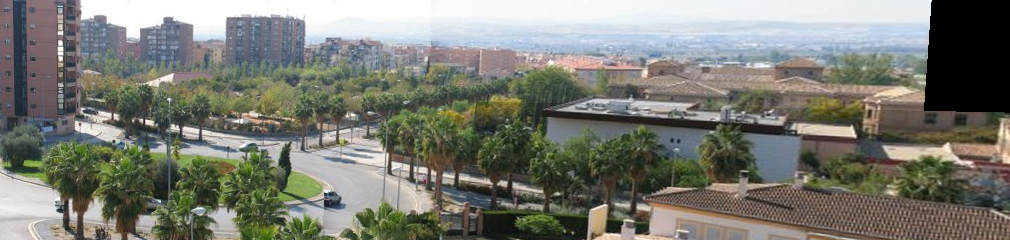

In [ ]:
## show 10 images after cropping 
imgs = [im1, im2, im3, im4, im5, im6, im7, im8, im9, im10]
out_10 = Image_Mosaic(imgs)
# print(out.shape)
roi = out_10[57:297, 60:1070] # crope image to exclude remined zero area
cv2_imshow(roi)

# # Saving the image
# filename = 'panorama_10_img.png'
# cv2.imwrite(filename, roi)